# Conjugate Gradient Descent

In [2]:
%run ~/.jupyter/config.ipy

In [40]:
import plots as p
import algos
import functions as funcs

from functools import partial
import matplotlib.pyplot as plt

import autograd.numpy as np
from autograd import grad, jacobian, hessian

assert "autograd" in np.__file__ # Need to make sure that we get the correct numpy - my config/other imports might import the default one.

# Linear CG

Remember that CG is used to solve a linear function,

$$
Ax = b
$$

by instead minimizing,

$$
\phi(x) = \frac{1}{2} x^T A x - b^T x
$$

as

$$
\nabla \phi(x) = Ax - b
$$

## 2d Example

In [35]:
A = np.array([
    [1, 0],
    [0, 3],
])
b = np.array([
    [0],
    [0],
])
x0 = np.array([[1], [0.3]])

In [36]:
positions = algos.conjugate_gradient(A, b.flatten(), x0.flatten())

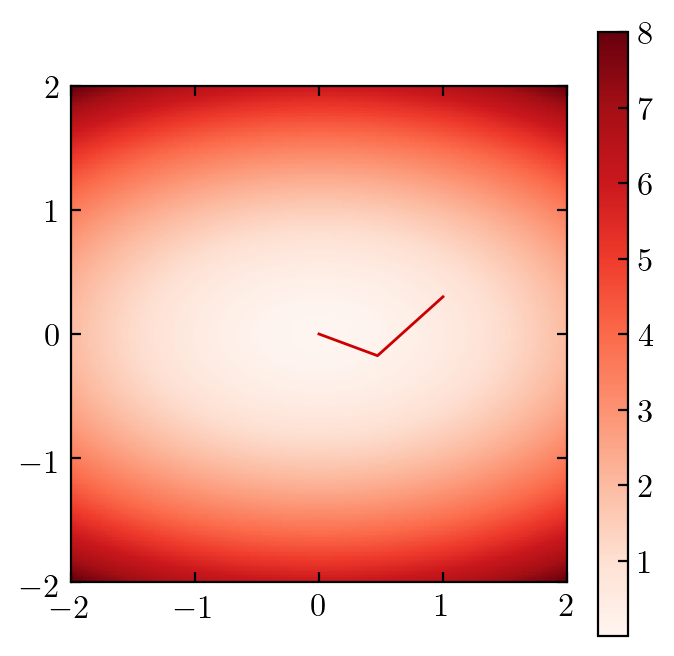

In [33]:
ax = p.surface_2d(partial(funcs.linear_system_phi, A, b), typ="image")
ax.plot(positions[0][:,0], positions[0][:,1])

## Large Example

Above we showed visually how CG works in a simple 2d problem. Now lets see how it performs in a large problem.

The first problem is to construct a large PSD $A$ matrix.

In [37]:
def construct_Ab_inputs(dims, eigenvalues):
    r = np.random.random((dims, dims))
    q, _ = np.linalg.qr(r)
    
    assert np.isclose(np.dot(q[:,0], q[:,1]), 0) # columns are orthogonal

    A = np.matmul(q.T, np.matmul(np.diag(eigenvalues), q))
    b = np.random.uniform(1, 10, size=dims)    
    return A, b

1001
253


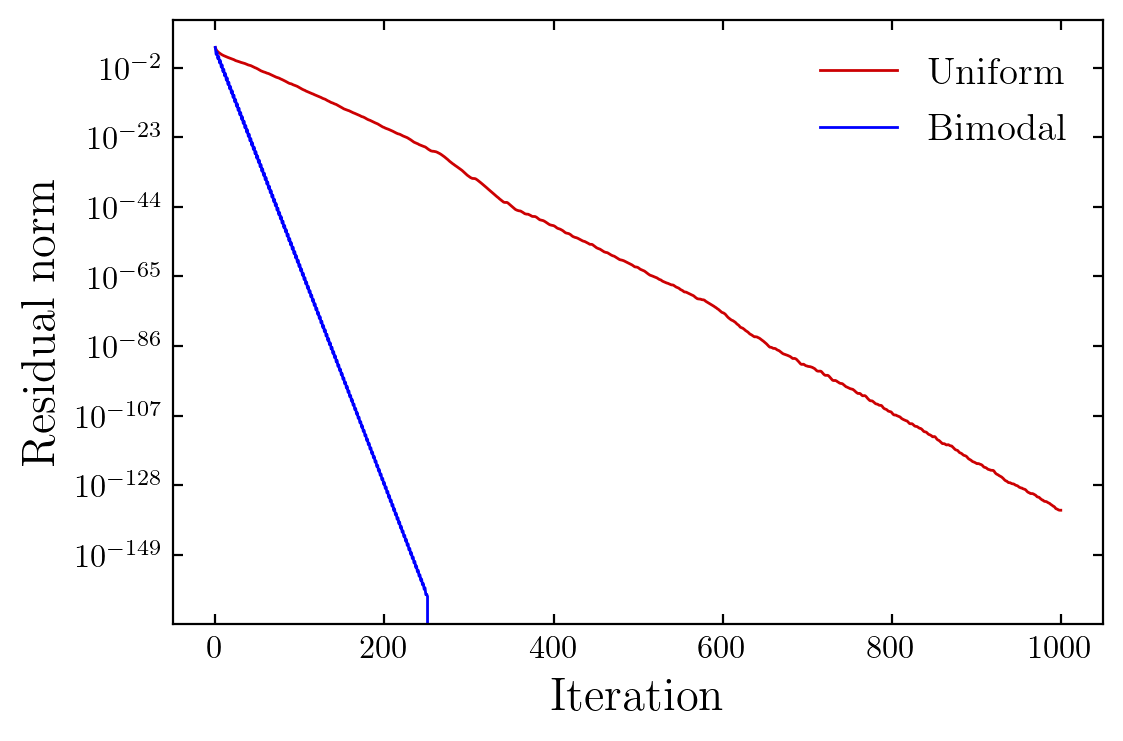

In [41]:
dims = int(1e3)
_, ax = plt.subplots()

for (ev, label) in [
    (np.random.uniform(10, 1000, size=dims), "Uniform"),
    (np.concatenate((np.random.uniform(9, 11, size=dims//2), np.random.uniform(999, 1001, size=dims//2))), "Bimodal"),
]:
    A, b = construct_Ab_inputs(dims, ev)
    x0 = np.random.random(dims)

    positions, residual_norm = algos.conjugate_gradient(A, b, x0)
    print(len(positions))

    assert np.allclose(np.matmul(A, positions[-1]), b)
    ax.plot(residual_norm, label=label)
ax.set(yscale="log", ylabel="Residual norm", xlabel="Iteration")
ax.legend()

# Nonlinear CG

## 2d Rosenbrock

Solved in 73 steps. Solution at [0.99999998 0.99999996]


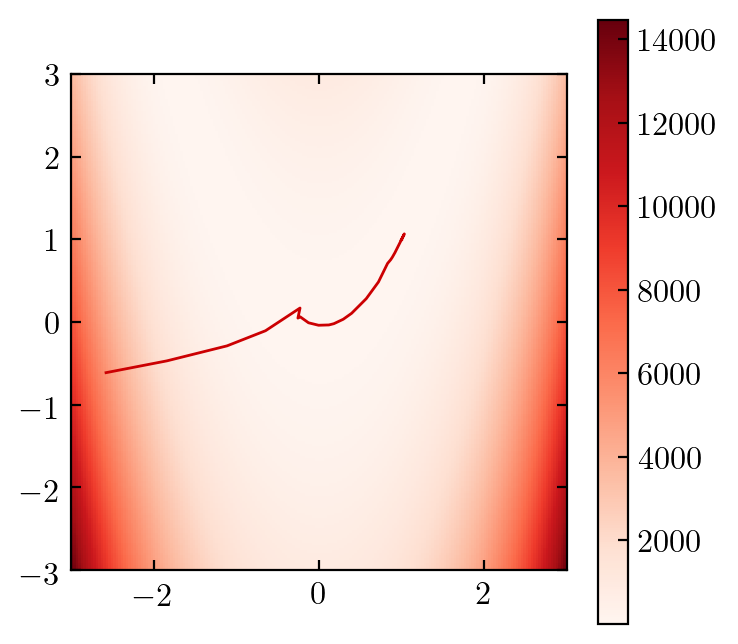

In [53]:
ax = p.surface_2d(funcs.rosenbrock, typ="image", lim=[-3, 3, -3, 3])

x0 = 6 * (np.random.random(size=2) - 0.5)
pos = algos.fletcher_reeves(funcs.rosenbrock, grad(funcs.rosenbrock), x0)

ax.plot(pos[:,0], pos[:,1])
print(f"Solved in {len(pos)} steps. Solution at {pos[-1]}")

## Large example

In [74]:
dims = 5
x0 = np.random.normal(size=dims)
def log_results(pos):   
    print(f"Final position is {pos[-1]} which is close to the known optimum? {np.allclose(pos[-1], 1)}")
    print(f"This took {len(pos)} steps")

In [75]:
for (args, name) in [
    #({"use_pr": False, "restart": None}, "FR"),
    ({"use_pr": False, "restart": 0.1}, "FR with restarts"),
    ({"use_pr": True, "restart": None}, "FR-PR"),
]:
    print(name)
    log_results(algos.fletcher_reeves(funcs.rosenbrock, grad(funcs.rosenbrock), x0, **args))

FR with restarts
Final position is [1.         1.         1.00000001 1.00000001 1.00000002] which is close to the known optimum? True
This took 258 steps
FR-PR
This might not work - this needs a modification to wolfe to ensure descent that I can't find...
Final position is [1.         0.99999999 0.99999999 0.99999998 0.99999996] which is close to the known optimum? True
This took 292 steps
